In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time
import configparser



#I/O 
spectra_filename = 'ARS_13_02'
now_path            =   '../BRILLOUIN/TDP43/' +spectra_filename +'/'

inputs = configparser.ConfigParser()

with open(now_path+'config.ini', 'r') as f:
    inputs.read_file(f)

############
#I/O 

VIPA_filename       =   inputs['I/O']['VIPA_filename']
log_file            =   'log_'+spectra_filename

#operatives
to_add              =   eval(inputs['Operatives']['to_add'])
exclude_delta       =   inputs.getboolean('Operatives', 'exclude_delta')

syg_kwargs          =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs')}
syg_kwargs_VIPA     =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_VIPA')}
syg_kwargs_brill    =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_brill')}
VIPA_treshold       =  inputs.getfloat('Operatives','VIPA_treshold')
sat_height          =  inputs.getfloat('Operatives','sat_height')
sat_width           =  inputs.getfloat('Operatives','sat_width')
almost_treshold     =  inputs.getfloat('Operatives','almost_treshold')
pre_cut             =  inputs.getboolean('Operatives','pre_cut')
cut                 =  inputs.getboolean('Operatives','cut')
mean_dist_01        =  inputs.getfloat('Operatives','mean_dist_01')
mean_dist_23        =  inputs.getfloat('Operatives','mean_dist_23')
#markov_fit

recover_markov      = inputs.getboolean('Markov', 'recover_markov')
p0_normal           = np.array(eval(inputs['Markov']['p0_normal']))
p0_brillouin        = np.array(eval(inputs['Markov']['p0_brillouin']))
p0_almost           = np.array(eval(inputs['Markov']['p0_almost']))

rules_markov_bounds =   eval(inputs['Markov']['rules_markov_bounds'])
#tot fit
skip_tot            =  inputs.getboolean('Tot', 'skip_tot')
rules_tot_bounds    =   eval(inputs['Tot']['rules_tot_bounds'])


############


cols_basic  = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude')
cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark_nodelta  = ('Co', 'Omega', 'Gamma', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


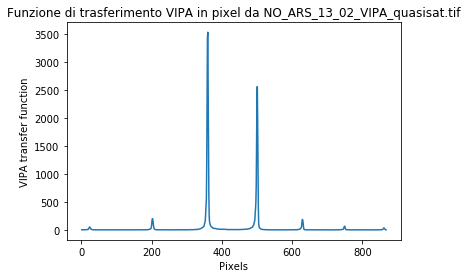

Text(0.5, 1.0, '(12, 35)')

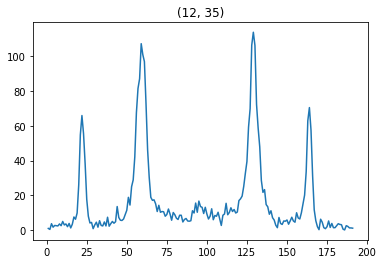

In [21]:
#0) importo dati e inizializzo oggetti
i   =   12
j   =   35
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = pre_cut, cut_range = (10, 175))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.title(str((i,j)))

Lo spettro è brillouin_highest_dx
Lo spettro ha 4 picchi


Text(0.5, 1.0, '(12, 35)')

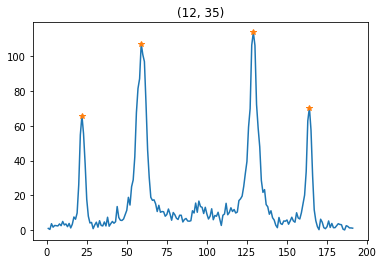

In [22]:
#1) Classificazione e visualizzazione spettro
check = Data.Check_Spectrum_Saturation(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    (Data.n_peaks == 2) :

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    if (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][1]]) & (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][3]]):
        nature    = 'brillouin_highest_dx'
    elif (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][2]]) & (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][0]]):
        nature    = 'brillouin_highest_sx'
    else:
        raise ValueError ('Non ho riconosciuto lo spettro\n')

elif (Data.n_peaks == 3) :
    Data.Get_Spectrum_Peaks(**syg_kwargs_brill) 
    nature = 'brillouin_higher'

elif Data.y.max() > almost_treshold:
    nature = 'almost_height'
else:                 nature    = 'normal'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))
plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks['idx']], Data.y[Data.peaks['idx']], '*')
plt.title(str((i,j)))

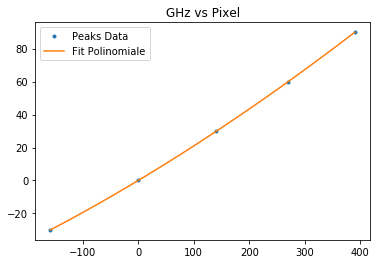

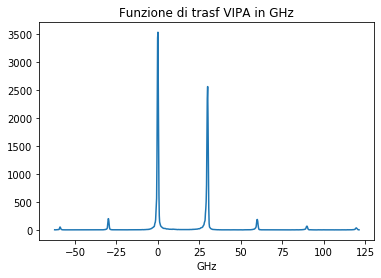

In [23]:
#2) Operazioni di conversione in GHz

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)


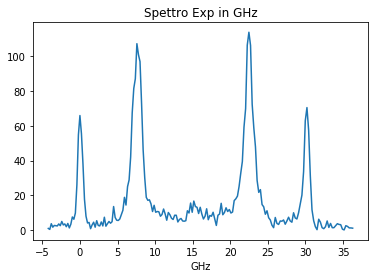

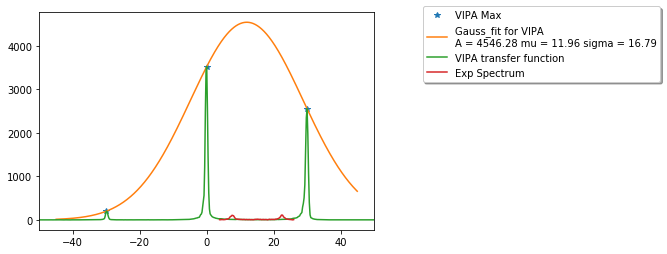

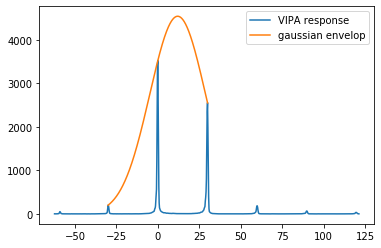

In [24]:
#3) Eseeguo taglio e stima parametri iniziali spettro, verifichepositive
from Alessandria import gaussian
Data.Align_Spectrum()
Data.Spectrum_Pix2GHz(fig = True)
Data.Cut_n_Estimate_Spectrum(estimate = True, cut = cut, mean_dist01 = mean_dist_01, mean_dist23 = mean_dist_23, verbose = True)
Data.Fit_VIPA_Gaussian(fig = True)
plt.figure()
plot(Data.x_VIPA_freq, Data.y_VIPA, label = 'VIPA response')
x = np.linspace(-30,30,1000)
plt.plot(x, gaussian(x, *Data.p0[list(cols_gauss)].values[0]), label = 'gaussian envelop')
plt.legend()

Cost before fitting = 108971.2107148804
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0897e+05                                    2.22e+05    
       1              2         2.3638e+04      8.53e+04       5.49e+02       5.07e+04    
       2              3         5.6299e+03      1.80e+04       1.09e+02       1.26e+04    
       3              4         1.4493e+03      4.18e+03       1.41e+02       5.25e+03    
       4              5         4.7754e+02      9.72e+02       7.96e+02       2.86e+03    
       5              6         2.3329e+02      2.44e+02       5.04e+02       3.33e+03    
       6              7         1.0662e+02      1.27e+02       4.62e+02       4.56e+02    
       7              8         8.8772e+01      1.78e+01       8.62e+02       1.80e+02    
       8              9         7.7310e+01      1.15e+01       1.32e+03       8.70e+02    
       9             10         7.2710e+01      4.

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.013111,7.555165,0.182075,0.101097,0.000724,0.002459,3.757162e+03,11.842649,16.774033,0.187801,1.999164
StdErrs,0.013293,0.022863,0.015529,0.003556,0.026949,0.069600,4.949715e+09,9.278693,28.190443,0.022171,0.551476
Initials,0.010000,7.448669,0.100000,0.000000,0.100000,1.000000,4.546282e+03,11.962272,16.790802,0.000000,0.000000


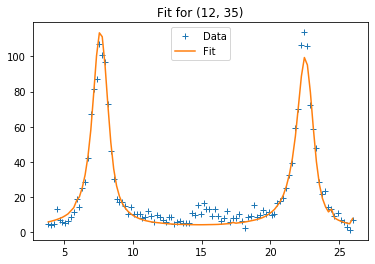

In [25]:
#3) fit markoviano
exclude_delta = False

if (exclude_delta) & (nature != 'almost_height'):
    print('porcodio')
    columns = cols_mark_nodelta
    Data.Get_Fit_Bounds(rules_markov_bounds[0:3]+rules_markov_bounds[6:], columns)
else:
    columns = cols_mark
    Data.Get_Fit_Bounds(rules_markov_bounds, columns)

Data.Get_VIPA_for_fit(mode = 'interpolate', interpolation_density = 500)

p0s = [Data.p0[list(columns)].values[0]]#, p0_almost, p0_brillouin, p0_normal]
Data.Get_Best_p0(p0s, columns)
Data.Get_cost_markov(Data.p0[list(columns)].values[0], columns = columns)
print('Cost before fitting = {}'.format(Data.cost_markov))

_= Data.Non_Linear_Least_Squares_Markov(columns, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, max_nfev = 200, fig = True, zoom = False)
#_ = Data.Non_Linear_Least_Squares_Markov(bound = (Data.bounds['down'].values, Data.bounds['up'].values),  max_nfev = 500)
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0], columns = columns)
print('Cost after fitting = {}\n'.format(Data.cost_markov))
Data.Markov_Fit_Params

In [26]:
Data.Markov_Fit_Params.values[0]

array([1.31108202e-02, 7.55516459e+00, 1.82075442e-01, 1.01096705e-01,
       7.24149688e-04, 2.45949290e-03, 3.75716229e+03, 1.18426495e+01,
       1.67740334e+01, 1.87800621e-01, 1.99916383e+00])

In [8]:
Data.Markov_Fit_Params

NameError: name 'Data' is not defined

In [10]:
_ = Data.Gauss_Convolve_Markovian_Response(Data.Markov_Fit_Params.values[0], fantoccio = (-50, 50), fig = True, compare = True)
plt.ylim(-10, 250)

NameError: name 'Data' is not defined

In [12]:
#4) fit totale
rules_tot_bounds                    =   (0.2, 0.01, 0.01, 'positive', 'positive', 0.01, 0.01, 0.01, 'inf', 0.5)
print(Data.p0[list(cols_mark)])
Data.Initials_Parameters_from_Markov(Data.Markov_Fit_Params, cols_mark)
print(Data.p0[list(cols_mark)])
Data.Get_Fit_Bounds(rules_tot_bounds, columns = cols_real)
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]
#Data.Get_p0(Data.p0[list(cols_real)].values[0], cols_real)
Data.Non_Linear_Least_Squares(p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50)
Data.Tot_Fit_Params

NameError: name 'Data' is not defined

In [13]:
p0 = np.array([1.21281641e-02, 7.72206371e+00, 1.94690324e-01, 0,
       0,1.35547082e+00, 5.10605549e-01, 8.38919312e-01,
       1.82962060e-02, 1.00000000e+00])
kernel                  =       Data.VIPA_w_j/(p_gauss[0]*(np.exp(-((Data.w_j_VIPA-p_gauss[1])**2)/(2*(p_gauss[2]**2)))))
_ = Data.Convolve_Theoretical_Response(Data.p0, p_gauss, kernel, fig = True, fantoccio = (-50, 50))
plt.plot(Data.x_freq, Data.y, '+', label = 'data')
plt.plot(Data.x_freq, Data.y_markov_fit, '--', label = 'markov')
plt.plot(Data.x_freq, Data.y_fit, '-.', label = 'tot')
plt.legend()
plt.xlim(-35, 10)
plt.ylim(-10, 400)

NameError: name 'Data' is not defined

In [14]:
_ = S_2_Generate(*Data.Tot_Fit_Params.values[0][0:8], -15, 15, 200, fig = True )

NameError: name 'Data' is not defined

In [15]:
cols_real

NameError: name 'cols_real' is not defined

In [16]:
from Models import S_Dynamical_Form_Factor_2_nodelta
def S_2_Generate(Co, Omega, Gamma, Delta, tau, delta_position, delta_width, delta_amplitude, x_min, x_max, density, fig = False):

    x   =   np.linspace(x_min,x_max,  density)
    y   =   lorentian(x, delta_position, delta_width, delta_amplitude) + S_Dynamical_Form_Factor_2_nodelta(x, Co, Omega, Gamma, Delta, tau)

    
    if fig:
        
        plt.figure()
        plt.title('S_2 generated data')
        plt.plot(x,y,'.')


    return (x,y)

In [17]:
p0  = Data.p0
Markov_Fit_Params = Data.Markov_Fit_Params
p0

NameError: name 'Data' is not defined

In [18]:
p0[list(cols_mark)].update(Markov_Fit_Params)
p0

NameError: name 'cols_mark' is not defined

In [19]:
p0

array([0.01212816, 7.72206371, 0.19469032, 0.        , 0.        ,
       1.35547082, 0.51060555, 0.83891931, 0.01829621, 1.        ])